# Transfer Learning CIFAR10

* Train a simple convnet on the CIFAR dataset the first 5 output classes [0..4].
* Freeze convolutional layers and fine-tune dense layers for the last 5 ouput classes [5..9].


In [329]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
#Importing required modules
from keras.datasets import cifar10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Reshape, Dense, Dropout, BatchNormalization, Activation, Conv2D, MaxPool2D, Flatten
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### 1. Import CIFAR10 data and create 2 datasets with one dataset having classes from 0 to 4 and other having classes from 5 to 9 

Few steps below visualize the dataset

Checking shape, image labels, plotting, type etc.

In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [332]:
print('Shape of x_train:',x_train.shape)
print('Shape of x_test:',x_test.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of y_test:',y_test.shape)

Shape of x_train: (50000, 32, 32, 3)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of y_test: (10000, 1)


In [333]:
print('Type of x_train:',x_train.dtype)
print('Type of x_test:',x_test.dtype)
print('Type of y_train:',y_train.dtype)
print('Type of y_test:',y_test.dtype)

Type of x_train: uint8
Type of x_test: uint8
Type of y_train: uint8
Type of y_test: int64


In [334]:
#Checking Unique number of labels or classes in the training data
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [335]:
#Checking Unique number of labels or classes in the training and test data
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

In [0]:
cifar10_classes_array = np.array(cifar10_classes)

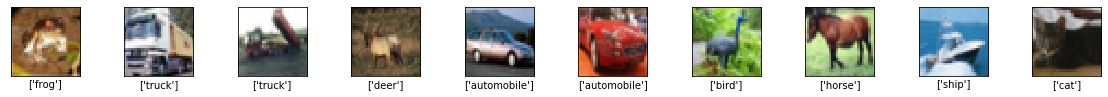

In [338]:
#plotting first 10 images in training sample
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(10):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(cifar10_classes_array[y_train[i]])
plt.show()

Example training images and their labels: [6, 9, 9, 4, 1]
Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


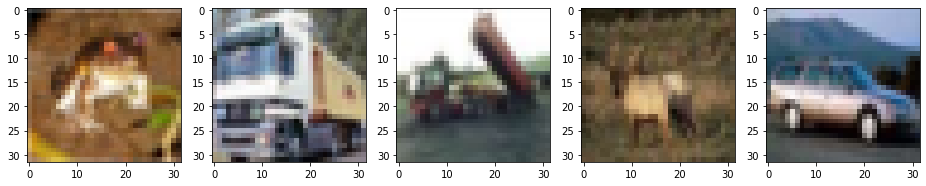

In [339]:
import matplotlib.pyplot as plt

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Example training images and their labels: ' + str([x[0] for x in y_train[0:5]])) 
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_train[0:5]]))

f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)

for i in range(5):
    img = x_train[i]
    axarr[i].imshow(img)
plt.show()

Counting the number of unique labels in training set

In [340]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]


Counting the number of unique labels in test set

In [341]:
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]


Next few Steps to create datasets of labels 0 to 4 and 5 to 9.
Following has been done to achieve this - reshaping, converting to dataframes , creating dataframes based on labels, dataframe to array conversion and reshaping arrays to the dimension compatible with image processing.

Reshaping training and test data from 4D to 2D to create dataframe

In [0]:
x_train2D = np.reshape(x_train,(50000,3072))
x_test2D = np.reshape(x_test,(10000,3072))

In [343]:
print('Shape of reshaped training data: ')
print(x_train2D.shape)
print('Shape of reshaped training data: ')
print(x_test2D.shape)

Shape of reshaped training data: 
(50000, 3072)
Shape of reshaped training data: 
(10000, 3072)


Creating pandas dataframe

In [0]:
df_train = pd.DataFrame(x_train2D)
df_test = pd.DataFrame(x_test2D)

Adding training and test data class columns to training and test dataframes respectively

In [0]:
df_train['class'] = y_train
df_test['class'] = y_test

Checking created dataframe

In [346]:
print('Shape of training dataframe',df_train.shape)
print('Shape of test dataframe',df_test.shape)

Shape of training dataframe (50000, 3073)
Shape of test dataframe (10000, 3073)


In [347]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071,class
0,59,62,63,43,46,45,50,48,43,68,54,42,98,73,52,119,91,63,139,107,75,145,110,80,149,117,89,149,120,93,131,103,77,125,99,76,142,115,91,144,...,148,103,77,161,105,69,144,95,55,112,90,59,119,91,58,130,96,65,120,87,59,92,67,46,103,78,57,170,140,104,216,184,140,151,118,84,123,92,72,6
1,154,177,187,126,137,136,105,104,95,102,101,99,125,131,139,155,166,180,172,190,210,180,199,214,142,156,156,111,120,110,106,107,98,109,104,102,123,121,117,127,...,5,6,11,6,6,11,10,9,12,25,22,22,51,45,42,68,64,67,90,90,101,116,113,122,134,127,133,140,130,136,143,133,139,143,134,142,143,133,144,9
2,255,255,255,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,...,76,90,90,72,86,86,64,78,78,64,78,78,69,83,83,66,80,80,55,69,69,52,66,66,58,72,72,68,80,79,78,85,83,79,85,83,80,86,84,9
3,28,25,10,37,34,19,38,35,20,42,37,23,44,39,25,40,37,22,40,38,23,24,23,9,32,25,15,43,27,19,30,20,10,32,30,17,41,37,23,52,...,122,99,67,107,85,54,112,96,66,92,81,53,80,62,39,96,78,59,77,67,42,85,76,44,84,75,48,67,57,38,54,47,28,63,56,37,72,65,46,4
4,170,180,198,168,178,196,177,185,203,183,193,211,181,196,218,177,195,220,181,195,223,184,192,223,189,190,223,189,189,222,188,193,224,183,194,223,182,194,223,184,...,93,98,102,90,95,99,88,93,97,83,89,92,77,87,88,75,84,85,71,81,82,74,80,83,72,76,79,71,75,78,75,79,82,71,75,78,73,77,80,1


Creating dataframe with class 0 to 4 from training and test dataframes

In [0]:
df1_train = df_train[df_train['class'] < 5]
df1_test = df_test[df_test['class'] < 5]

In [349]:
print('Unique class values in created dataframe df1_train: ', df1_train['class'].unique())
print('Unique class values in created dataframe df1_test: ', df1_test['class'].unique())

Unique class values in created dataframe df1_train:  [4 1 2 3 0]
Unique class values in created dataframe df1_test:  [3 0 1 4 2]


In [350]:
df1_train.shape

(25000, 3073)

Creating dataframe with class 5 to 9

In [0]:
df2_train = df_train[df_train['class'] > 4]
df2_test = df_test[df_test['class'] > 4]

In [352]:
print('Unique class values in created dataframe df2_train: ', df2_train['class'].unique())
print('Unique class values in created dataframe df2_test: ', df2_test['class'].unique())

Unique class values in created dataframe df2_train:  [6 9 7 8 5]
Unique class values in created dataframe df2_test:  [8 6 9 5 7]


In [353]:
df2_train.shape

(25000, 3073)

Separating data and class in train and test dataframes

In [0]:
x_train1 = df1_train.drop('class', axis=1)
y_train1 = df1_train['class']
x_test1 = df1_test.drop('class',axis=1)
y_test1 = df1_test['class']

In [0]:
x_train2 = df2_train.drop('class', axis=1)
y_train2 = df2_train['class']
x_test2 = df2_test.drop('class', axis=1)
y_test2 = df2_test['class']

Creating numpy array from dataframe

In [0]:
x_train1 = np.array(x_train1)
x_test1 = np.array(x_test1)
y_train1 = np.array(y_train1)
y_test1 = np.array(y_test1)

In [0]:
x_train2 = np.array(x_train2)
x_test2 = np.array(x_test2)
y_train2 = np.array(y_train2)
y_test2 = np.array(y_test2)

Reshape to original array size

In [358]:
print('Shape of x_train1: ',x_train1.shape)
print('Shape of x_test1: ',x_test1.shape)
print('Shape of x_train2: ',x_train2.shape)
print('Shape of x_test2: ',x_test2.shape)

Shape of x_train1:  (25000, 3072)
Shape of x_test1:  (5000, 3072)
Shape of x_train2:  (25000, 3072)
Shape of x_test2:  (5000, 3072)


In [0]:
x_train1_rgb = np.reshape(x_train1,(25000,32,32,3))
x_test1_rgb = np.reshape(x_test1,(5000,32,32,3))
x_train2_rgb = np.reshape(x_train2,(25000,32,32,3))
x_test2_rgb = np.reshape(x_test2,(5000,32,32,3))

Checking that images are retained after reshape to original dimensions

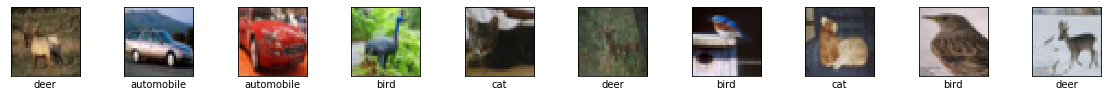

In [360]:
#plotting first 10 images in training sample
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(10):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train1_rgb[i])
    plt.xlabel(cifar10_classes_array[y_train1[i]])
plt.show()

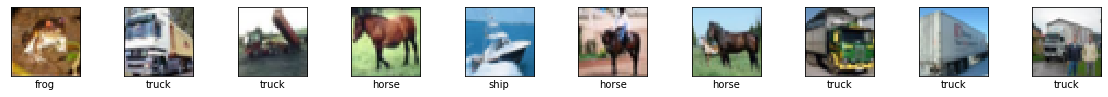

In [361]:
#plotting first 10 images in training sample
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(10):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train2_rgb[i])
    plt.xlabel(cifar10_classes_array[y_train2[i]])
plt.show()

Normalizing input

In [0]:
x_train1_rgb_norm = x_train1_rgb / 255.0
x_test1_rgb_norm = x_test1_rgb / 255.0
x_train2_rgb_norm = x_train2_rgb / 255.0
x_test2_rgb_norm = x_test2_rgb / 255.0

Changing data type to float32 for compatibility with Keras

In [0]:
#Converting fetched dataset into numpy array of data type float32 for compatibility with Keras
x_train1_rgb_norm = np.array(x_train1_rgb_norm).astype('float32')
x_test1_rgb_norm = np.array(x_test1_rgb_norm).astype('float32')
x_train2_rgb_norm = np.array(x_train2_rgb_norm).astype('float32')
x_test2_rgb_norm = np.array(x_test2_rgb_norm).astype('float32')

### 2. Use One-hot encoding to divide y_train and y_test into required no of output classes

In [0]:
y_train1_cat = tf.keras.utils.to_categorical(y_train1)
y_test1_cat = tf.keras.utils.to_categorical(y_test1)

In [0]:
y_train2_cat = tf.keras.utils.to_categorical(y_train2)
y_test2_cat = tf.keras.utils.to_categorical(y_test2)

### 3. Build a sequential neural network model which can classify the classes 0 to 4 of CIFAR10 dataset with at least 80% accuracy on test data

In [0]:
clear_session()
# Initializing the CNN model
model = Sequential()

#normalize data
model.add(BatchNormalization(input_shape=(32,32,3,),name='input'))

# BatchNormalization layer
model.add(BatchNormalization(name='batchNorm_1'))

### Apply Convolutional Layers, MaxPooling
#Add first convolutional layer
model.add(Conv2D(32, #Number of filters 
                                 kernel_size=(3,3), #Size of the filter
                                activation='relu', name = 'conv_1'))

# BatchNormalization layer
model.add(BatchNormalization(name='batchNorm_2'))

#Add second convolutional layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', name = 'conv_2'))

# BatchNormalization layer
model.add(BatchNormalization(name='batchNorm_3'))

#Add Dropout
model.add(Dropout(0.25, name = 'dropout_1'))

#Add MaxPooling layer
model.add(MaxPool2D(pool_size=(2,2), name = 'maxPool_1'))

#Add third convolutional layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', name = 'conv_3'))

#Add MaxPooling layer
model.add(MaxPool2D(pool_size=(2,2), name = 'maxPool_2'))

#Flatten the output
model.add(Flatten(name = 'flatten'))


#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model.add(Dense(128, activation='relu',name='dense_1'))

# BatchNormalization layer
model.add(BatchNormalization(name='batchNorm_4'))

#Apply Dropout with 0.5 probability 
model.add(Dropout(0.5,name='dropout_2'))

#Add Fully Connected Layer with 32 units and activation function as 'ReLU'
model.add(Dense(32, activation='relu',name='dense_2'))

# BatchNormalization layer
model.add(BatchNormalization(name='batchNorm_5'))

#Apply Dropout with 0.25 probability 
model.add(Dropout(0.25,name='dropout_3'))

# Adding the output layer using softmax as activation function
model.add(Dense(units=5, activation = 'softmax', name = 'dense_3'))

In [0]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [368]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (BatchNormalization)   (None, 32, 32, 3)         12        
_________________________________________________________________
batchNorm_1 (BatchNormalizat (None, 32, 32, 3)         12        
_________________________________________________________________
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batchNorm_2 (BatchNormalizat (None, 30, 30, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 64)        18496     
_________________________________________________________________
batchNorm_3 (BatchNormalizat (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0

In [369]:
model.fit(x_train1_rgb_norm, y_train1_cat, validation_data=(x_test1_rgb_norm, y_test1_cat), batch_size=32, epochs=10)

Train on 25000 samples, validate on 5000 samples
Epoch 1/10
25000/25000 [==============================] - 149s 6ms/sample - loss: 1.0868 - accuracy: 0.5689 - val_loss: 0.8924 - val_accuracy: 0.6332
Epoch 2/10
25000/25000 [==============================] - 150s 6ms/sample - loss: 0.8043 - accuracy: 0.6932 - val_loss: 0.8745 - val_accuracy: 0.6698
Epoch 3/10
25000/25000 [==============================] - 148s 6ms/sample - loss: 0.6822 - accuracy: 0.7484 - val_loss: 0.7877 - val_accuracy: 0.7158
Epoch 4/10
25000/25000 [==============================] - 147s 6ms/sample - loss: 0.6156 - accuracy: 0.7749 - val_loss: 0.7061 - val_accuracy: 0.7528
Epoch 5/10
25000/25000 [==============================] - 148s 6ms/sample - loss: 0.5621 - accuracy: 0.7967 - val_loss: 0.7310 - val_accuracy: 0.7494
Epoch 6/10
25000/25000 [==============================] - 147s 6ms/sample - loss: 0.5180 - accuracy: 0.8141 - val_loss: 0.5847 - val_accuracy: 0.7882
Epoch 7/10
25000/25000 [===========================

In [370]:
#Testing the model on test set
score = model.evaluate(x_test1_rgb_norm, y_test1_cat)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5000/5000 [==============================] - 6s 1ms/sample - loss: 0.5860 - accuracy: 0.8036
Test loss: 0.5860213494420051
Test accuracy: 0.8036


### 4. In the model which was built above (for classification of classes 0-4 in CIFAR10), make only the dense layers to be trainable and conv layers to be non-trainable

In [371]:
#Freezing layers in the model which don't have 'dense' in their name
for layer in model.layers:
  if('dense' not in layer.name): #prefix detection to freeze layers which does not have dense
    #Freezing a layer
    layer.trainable = False

#Module to print colourful statements
from termcolor import colored

#Check which layers have been frozen 
for layer in model.layers:
  print (colored(layer.name, 'blue'))
  print (colored(layer.trainable, 'red'))

input
False
batchNorm_1
False
conv_1
False
batchNorm_2
False
conv_2
False
batchNorm_3
False
dropout_1
False
maxPool_1
False
conv_3
False
maxPool_2
False
flatten
False
dense_1
True
batchNorm_4
False
dropout_2
False
dense_2
True
batchNorm_5
False
dropout_3
False
dense_3
True


In [372]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (BatchNormalization)   (None, 32, 32, 3)         12        
_________________________________________________________________
batchNorm_1 (BatchNormalizat (None, 32, 32, 3)         12        
_________________________________________________________________
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batchNorm_2 (BatchNormalizat (None, 30, 30, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 64)        18496     
_________________________________________________________________
batchNorm_3 (BatchNormalizat (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0

### 5. Utilize the the model trained on CIFAR 10 (classes 0 to 4) to classify the classes 5 to 9 of CIFAR 10  (Use Transfer Learning) <br>
Achieve an accuracy of more than 85% on test data

As number of output classes are same for another dataset (with classes 5 to 9) but after one hot encoding, output classes will be 10.Adding one output layer with 10 outputs in the trained model.

In [0]:
#get Output layer of Pre0trained model
x = model.output

#Add output layer
prediction = tf.keras.layers.Dense(10,activation='softmax', name = 'dense_4')(x)

In [0]:
#Using Keras Model class
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

In [0]:
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [376]:
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_input (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
input (BatchNormalization)   (None, 32, 32, 3)         12        
_________________________________________________________________
batchNorm_1 (BatchNormalizat (None, 32, 32, 3)         12        
_________________________________________________________________
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batchNorm_2 (BatchNormalizat (None, 30, 30, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 64)        18496     
_________________________________________________________________
batchNorm_3 (BatchNormalizat (None, 28, 28, 64)        256   

In [317]:
final_model.fit(x_train2_rgb_norm, y_train2_cat, validation_data=(x_test2_rgb_norm, y_test2_cat), batch_size=32, epochs=10)

Train on 25000 samples, validate on 5000 samples
Epoch 1/10
25000/25000 [==============================] - 53s 2ms/sample - loss: 1.5277 - accuracy: 0.5026 - val_loss: 1.1761 - val_accuracy: 0.5552
Epoch 2/10
25000/25000 [==============================] - 51s 2ms/sample - loss: 1.0548 - accuracy: 0.5656 - val_loss: 0.9573 - val_accuracy: 0.5832
Epoch 3/10
25000/25000 [==============================] - 52s 2ms/sample - loss: 0.8991 - accuracy: 0.6044 - val_loss: 0.8484 - val_accuracy: 0.6714
Epoch 4/10
25000/25000 [==============================] - 52s 2ms/sample - loss: 0.8063 - accuracy: 0.6603 - val_loss: 0.7811 - val_accuracy: 0.6866
Epoch 5/10
25000/25000 [==============================] - 52s 2ms/sample - loss: 0.7168 - accuracy: 0.7394 - val_loss: 0.6416 - val_accuracy: 0.8304
Epoch 6/10
25000/25000 [==============================] - 52s 2ms/sample - loss: 0.5237 - accuracy: 0.8482 - val_loss: 0.4809 - val_accuracy: 0.8672
Epoch 7/10
25000/25000 [==============================] -

In [318]:
#Testing the model on test set
score = final_model.evaluate(x_test2_rgb_norm, y_test2_cat)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5000/5000 [==============================] - 6s 1ms/sample - loss: 0.4239 - accuracy: 0.8722
Test loss: 0.423904385471344
Test accuracy: 0.8722


# Text classification using TF-IDF

### 6. Load the dataset from sklearn.datasets

In [0]:
from sklearn.datasets import fetch_20newsgroups

In [0]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

### 7. Training data

In [379]:
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

### 8. Test data

In [0]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

###  a.  You can access the values for the target variable using .target attribute 
###  b. You can access the name of the class in the target variable with .target_names


In [381]:
twenty_train.target

array([1, 1, 3, ..., 2, 2, 2])

In [382]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [383]:
twenty_train.data[0:5]

['From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n',
 "From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\nSubject: help: Splitting a trimming region along a mesh \nOrganization: University Of Kentucky, Dept. of Math Sciences\nLines: 28\n\n\n\n\tHi,\n\n\tI have a problem, I hope some of the 'gurus' can help me solve.\n\n\tBackground of the probl

### 9.  Now with dependent and independent data available for both train and test datasets, using TfidfVectorizer fit and transform the training data and test data and get the tfidf features for both

In [0]:
# TfidfVectorizer
vect = TfidfVectorizer()

Creating Document Term Matrix for training and test data

In [0]:
X_train_dtm = vect.fit_transform(twenty_train.data)
X_test_dtm = vect.transform(twenty_test.data)

In [386]:
print('Shape of training data DTM: ')
print(X_train_dtm.shape)
print('Shape of test data DTM: ')
print(X_test_dtm.shape)

Shape of training data DTM: 
(2257, 35788)
Shape of test data DTM: 
(1502, 35788)


Printing feature names for training and test data

In [387]:
print('features in training data: ')
print(vect.get_feature_names())

features in training data: 
['00', '000', '0000', '0000001200', '000005102000', '0001', '000100255pixel', '00014', '000406', '0007', '000usd', '0010', '001004', '0010580b', '001125', '001200201pixel', '0014', '001642', '00196', '002', '0028', '003258u19250', '0033', '0038', '0039', '004021809', '004158', '004627', '0049', '00500', '005148', '00630', '008561', '0094', '00am', '00index', '00pm', '01', '0100', '010116', '010702', '011255', '011308pxf3', '011605', '011720', '012019', '012536', '012946', '013', '013034', '0131', '013423tan102', '013657', '0138', '013846', '0150', '015518', '01580', '015931', '01720', '01752', '0179', '01821', '01830', '0184', '01852', '01854', '01890', '0195', '0199', '01a', '01wb', '02', '020', '0200', '020504', '020637', '020646', '020701tan102', '020751', '02115', '02118', '02139', '02142', '02154', '02160', '021635', '021708', '02173', '0223', '02254', '022621tan102', '023044', '0235', '0237', '024103', '024150', '024626', '025240', '025924', '0278', '0

Number of features in training data

In [388]:
len(vect.get_feature_names())

35788

In [389]:
pd.DataFrame(vect.fit_transform(twenty_train.data).toarray(), columns=vect.get_feature_names())

,00,000,0000,0000001200,000005102000,0001,000100255pixel,00014,000406,0007,000usd,0010,001004,0010580b,001125,001200201pixel,0014,001642,00196,002,0028,003258u19250,0033,0038,0039,004021809,004158,004627,0049,00500,005148,00630,008561,0094,00am,00index,00pm,01,0100,010116,...,zoerasterism,zola,zolf,zolft,zoloft,zombie,zonal,zone,zonker,zoo,zooid,zool,zoom,zooming,zooms,zopfi,zorasterism,zorg,zorn,zrz,zsoft,zt,zubkoff,zues,zug,zumder,zur,zurich,zurlo,zus,zvi,zvonko,zwart,zyeh,zyklon,zyxel,zz,zzz,ªl,íålittin
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.29521,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.055283,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057185,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.095199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2253,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2254,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2255,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [390]:
pd.DataFrame(vect.transform(twenty_test.data).toarray(), columns=vect.get_feature_names())

,00,000,0000,0000001200,000005102000,0001,000100255pixel,00014,000406,0007,000usd,0010,001004,0010580b,001125,001200201pixel,0014,001642,00196,002,0028,003258u19250,0033,0038,0039,004021809,004158,004627,0049,00500,005148,00630,008561,0094,00am,00index,00pm,01,0100,010116,...,zoerasterism,zola,zolf,zolft,zoloft,zombie,zonal,zone,zonker,zoo,zooid,zool,zoom,zooming,zooms,zopfi,zorasterism,zorg,zorn,zrz,zsoft,zt,zubkoff,zues,zug,zumder,zur,zurich,zurlo,zus,zvi,zvonko,zwart,zyeh,zyklon,zyxel,zz,zzz,ªl,íålittin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043979,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 10. Use logisticRegression with tfidf features as input and targets as output and train the model and report the train and test accuracy score

Defining y_train and y_test

In [0]:
y_train = twenty_train.target
y_test = twenty_test.target

Defining and train logistic regression model

In [392]:
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Applying model on test data and predict class

In [0]:
y_pred_class_test = logreg.predict(X_test_dtm)

Calculating Accuracy

In [394]:
#Applying model on training data for training accuracy calculation
y_pred_class_train = logreg.predict(X_train_dtm)
print('Training Accuracy: ', metrics.accuracy_score(y_train, y_pred_class_train))

Training Accuracy:  1.0


In [397]:
print('Test Accuracy: ', metrics.accuracy_score(y_test, y_pred_class_test))

Test Accuracy:  0.9154460719041279


Labels for the Text in test data is predicted with around 91.5 % accuracy with above logistic regression model